# Telco Churn

This notebook is an example on how to use the VerticaPy Library. We will use the Telco Churn dataset to predict which telco user will probably churn. You can download the Jupyter Notebook of the study by clicking <a href="churn.ipynb">here</a>. You can download the dataset of the study on Kaggle by clicking <a href="https://www.kaggle.com/blastchar/telco-customer-churn">here</a>. To achieve our goals, we have access to multiple information.
<ul class="ul_content">
    <li>Customers who left within the last month – the column is called Churn</li>
    <li>Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies</li>
    <li>Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges</li>
    <li>Demographic info about customers – gender, age range, and if they have partners and dependents</li>
</ul>

We will follow the entire Data Science cycle (Data Exploration - Data Preparation - Data Modeling - Model Evaluation - Model Deployment) and solve this easy use-case. The purpose is to show you some of the library interesting functionalities.


## Initialization

Let's create the Virtual DataFrame of the dataset.

In [1]:
from verticapy import *
churn = vDataFrame('churn')
print(churn)

<object>  Name: churn, Number of rows: 7043, Number of columns: 21


## Data Exploration and Preparation

Let's look at the different variables information.

In [2]:
churn.describe(method = "categorical")

<object>

Multiple variables are categorical and as they all have low cardinalities, we can compute their dummies. We can also convert all the booleans to numeric.

In [3]:
churn.bool_to_int().get_dummies().drop(
    ["StreamingMovies", "Contract", "gender", "PaymentMethod", 
     "StreamingTV", "InternetService", "DeviceProtection", "OnlineSecurity",
     "customerID", "OnlineBackup", "MultipleLines", "TechSupport"])

<object>  Name: churn, Number of rows: 7043, Number of columns: 31

Let's compute the correlations between the different variables and the response column.

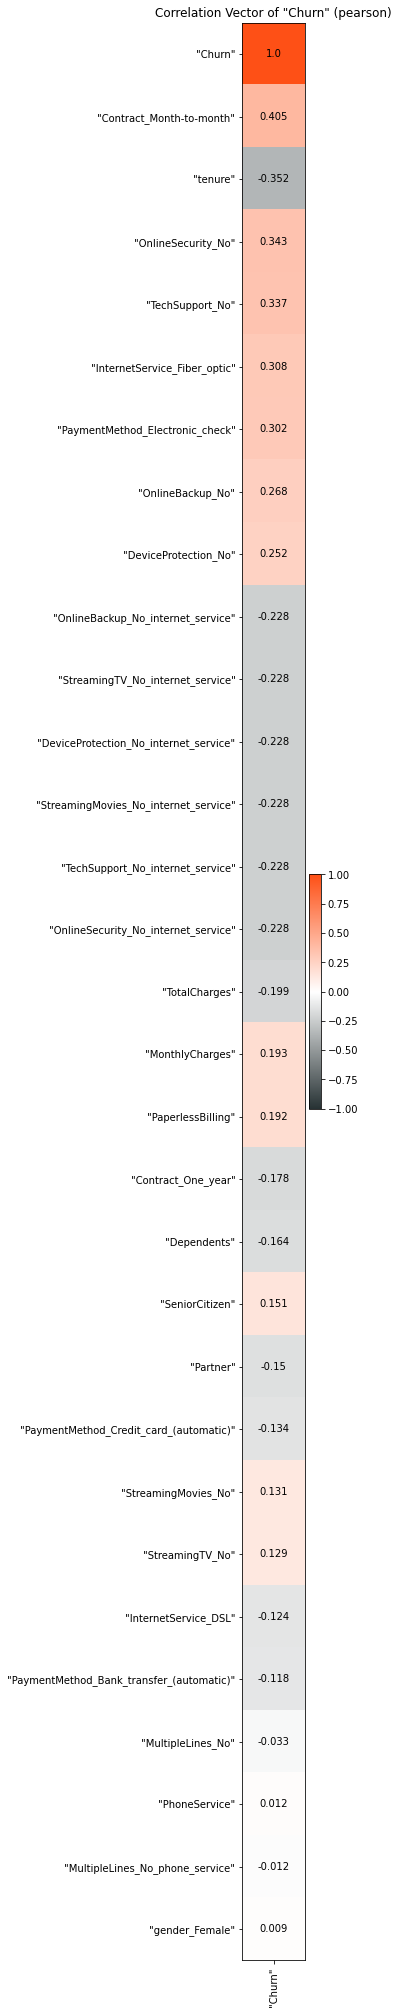

In [4]:
%matplotlib inline
x = churn.corr(focus = "Churn")

Many features are very correlated to the 'Churn' variable. For example, the customers having a 'Month to Month' contract are more sensible to churn. Indeed, having this type of contract provides a high flexiblity to the customer who can choose to leave the telco company anytime. Besides new customers are more sensible to churn.

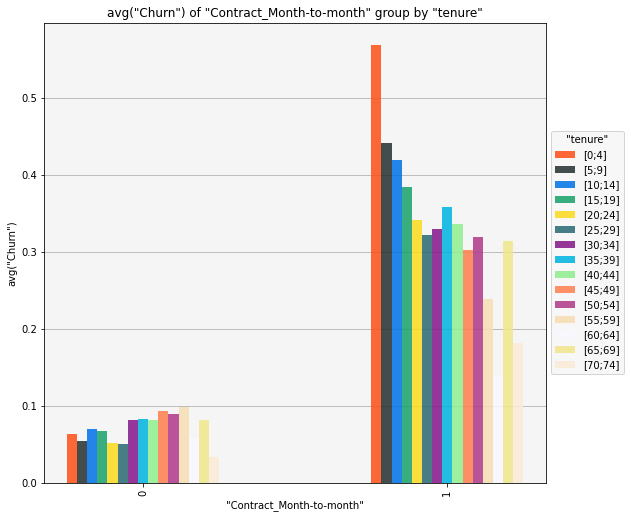

In [5]:
# No lock-in = Churn
x = churn.hist(["Contract_Month-to-month", "tenure"], method = "avg", of = "Churn")

We can notice in the following Scatter Plot that it is possible to provide better customized tariff plans to avoid churn. Indeed, customers having high total charges are more sensible to churn even if they have a high tenure.

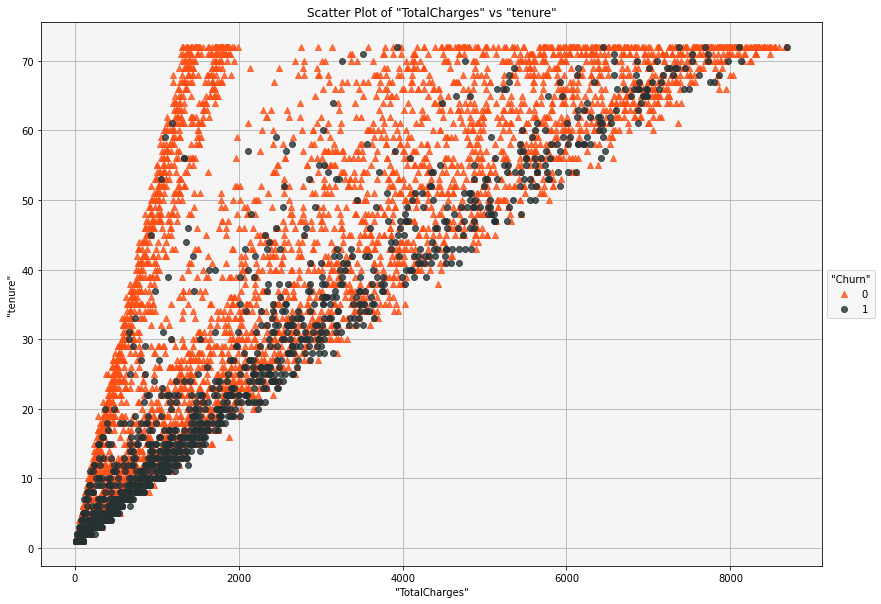

In [6]:
x = churn.scatter(["TotalCharges", "tenure"], catcol = "Churn")

Let's export the cleaned dataset in the Vertica Data Base.

In [7]:
drop_table("churn_clean")
churn.to_db("churn_clean", relation_type = "table")

The table churn_clean was successfully dropped.


<object>  Name: churn, Number of rows: 7043, Number of columns: 31

We can start using Machine Learning Algorithms.

## Machine Learning

Logistic Regression is a very powerful algorithm for Churn detection. Let's use a Cross Validation to evaluate our model.

In [8]:
from verticapy.learn.linear_model import LogisticRegression
model = LogisticRegression("churn_model", 
                           penalty = 'L2', 
                           tol = 1e-6, 
                           max_iter = 1000, 
                           solver = "BFGS")

from verticapy.learn.model_selection import cross_validate
cross_validate(model, 
               'churn_clean', 
               churn.get_columns(exclude_columns = ["churn"]), 
               'churn')

<object>

The model is excellent ! Let's learn on all the dataset and compute the features importance.

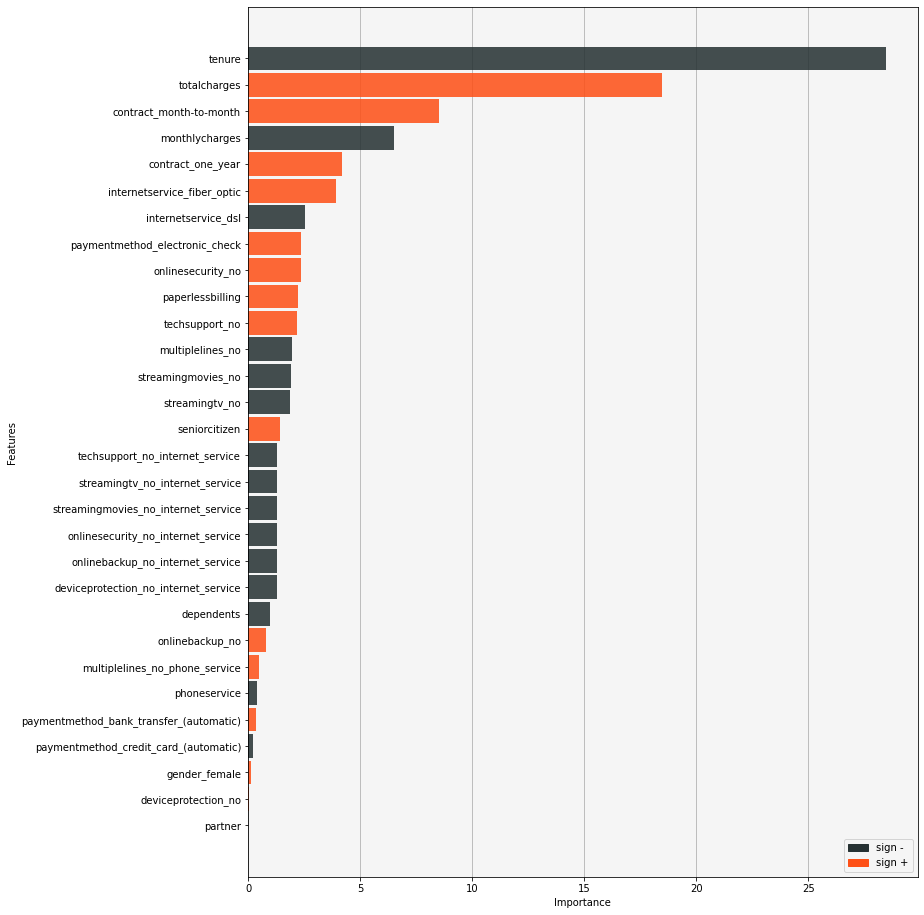

<object>

In [9]:
model.fit('churn_clean', 
          churn.get_columns(exclude_columns = ["churn"]), 
          'churn')
model.features_importance()

We can notice that most of the churning customers have at least one of the following characteristics.
<ul>
 <li>Paying more charges</li>
 <li>New to the Telco Company</li>
 <li>Have a Month-to-Month contract</li>
</ul>
We can also notice that Customers having the 'Fiber Optic' option tend more to churn. Let's verify if it is causal by computing some aggregations.

In [10]:
# Is Fiber optic a Bad Option? - VerticaPy

churn.groupby(["InternetService_Fiber_optic"], 
              ["AVG(tenure) AS tenure", 
               "AVG(totalcharges) AS totalcharges",
               'AVG("contract_month-to-month") AS "contract_month-to-month"',
               'AVG("monthlycharges") AS "monthlycharges"'])

<object>  Name: groupby, Number of rows: 2, Number of columns: 5

It seems that the 'Fiber Optic' option is not bad at all. Customers having this option tend to churn because of their type of contract and because they are paying more charges than the other customers.

## Conclusion

We have solved this use-case in a pandas-like way but we never loaded the data in memory. This example showed an overview of the library. You can now start your own project by looking at the documentation first.